In [49]:
using Rocket
using ReactiveMP
using GraphPPL
using Distributions
using Plots
using ColorSchemes
using Random
using LinearAlgebra
using Colors
using Printf

In [10]:
# Plot related calls

using PGFPlotsX

pgfplotsx()

PGFPlotsX.latexengine!(PGFPlotsX.PDFLATEX);

In [152]:
function generate_data(; seed, nmixtures, nsamples, L)
    Random.seed!(seed)

    probvec = ones(nmixtures)
    probvec = probvec ./ sum(probvec)

    switch = Categorical(probvec)

    gaussians = map(1:nmixtures) do index
        angle      = 2π / nmixtures * (index - 1)
        basis_v    = L * [ 1.0, 0.0 ]
        rotationm  = [ cos(angle) -sin(angle); sin(angle) cos(angle) ]
        mean       = rotationm * basis_v 
        covariance = Matrix(Hermitian(rotationm * [ 16.0 0.0; 0.0 1.0 ] * transpose(rotationm)))
        return MvNormal(mean, covariance)
    end

    z = rand(switch, nsamples)
    y = Vector{Vector{Float64}}(undef, nsamples)

    for i in 1:nsamples
        y[i] = rand(gaussians[z[i]])
    end
    
    return y
end

generate_data (generic function with 1 method)

In [153]:
sdim(n) = (a) -> map(d -> d[n], a)

sdim (generic function with 1 method)

In [158]:
seed = 123
nmixtures = 10
nsamples = 200
L = 30.0

y = generate_data(;
    seed      = seed,
    nmixtures = nmixtures,
    nsamples  = nsamples,
    L         = L
);

In [159]:
# We use mean field factorisation by default for Gaussian Mixture estimation
@model [ default_factorisation = MeanField() ] function gaussian_mixture_model(nmixtures, nsamples)
    
    z = randomvar(nsamples)
    m = randomvar(nmixtures) # A sequence of random variables for means
    w = randomvar(nmixtures) # A sequence of random variables for precision
    y = datavar(Vector{Float64}, nsamples) # A sequence of observed samples
    
    # We set uninformative priors for means and precisions
    for i in 1:nmixtures
        m[i] ~ MvGaussianMeanCovariance(zeros(2), [ 1e6 0.0; 0.0 1e6 ])
        w[i] ~ Wishart(2, [ 1e5 0.0; 0.0 1e5 ])
    end
    
    # Use uninformative prior for switching distribution
    s ~ Dirichlet(ones(nmixtures))
    
    # GaussianMixture node accepts means and precisions arguments in a form of tuple
    means = tuple(m...)
    precs = tuple(w...)
    
    # For each sample assign a switch ditribution to be Categorical and
    #  connect observed sample to a GaussianMixture node
    for i in 1:nsamples
        z[i] ~ Categorical(s)
        y[i] ~ GaussianMixture(z[i], means, precs)
    end
    
    return s, z, m, w, y
end

gaussian_mixture_model (generic function with 1 method)

In [160]:
import ProgressMeter

function inference(nmixtures, data, viters)
    n = length(data)
    
    model, (s, z, m, w, y) = gaussian_mixture_model(nmixtures, n)
    
    means_estimates  = Vector{Vector{Marginal}}()
    precs_estimates  = Vector{Vector{Marginal}}()
    switch_estimates = Vector{Marginal}()
    fe_values        = Vector{Float64}()
    
    fe_scheduler = PendingScheduler()

    switch_subscription = subscribe!(getmarginal(s), (m) -> push!(switch_estimates, m))
    means_subscription  = subscribe!(collectLatest(getmarginals(m)), (m) -> push!(means_estimates, m))
    precs_subscription  = subscribe!(collectLatest(getmarginals(w)), (m) -> push!(precs_estimates, m))
    fe_subscription     = subscribe!(score(BetheFreeEnergy(), model, fe_scheduler), (fe) -> push!(fe_values, fe))
    
    setmarginal!(s, vague(Dirichlet, nmixtures))
    
    basis_v = [ 1.0, 0.0 ]
    
    for i in 1:nmixtures
        angle_prior = (2π / nmixtures) * (i - 1)
        mean_mean_prior = [ cos(angle_prior) -sin(angle_prior); sin(angle_prior) cos(angle_prior) ] * basis_v
        mean_mean_cov   = [ 1e6 0.0; 0.0 1e6 ]
        
        setmarginal!(m[i], MvNormalMeanCovariance(mean_mean_prior, [ 1e6 0.0; 0.0 1e6 ]))
        setmarginal!(w[i], Wishart(2, [ 1e3 0.0; 0.0 1e3 ]))
    end
    
    ProgressMeter.@showprogress for i in 1:viters
        update!(y, data)
        release!(fe_scheduler)
    end
    
    unsubscribe!(means_subscription)
    unsubscribe!(precs_subscription)
    unsubscribe!(switch_subscription)
    unsubscribe!(fe_subscription)
    
    return switch_estimates, means_estimates, precs_estimates, fe_values
end

inference (generic function with 1 method)

In [161]:
s, m, w, fe = inference(nmixtures, y, 15);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


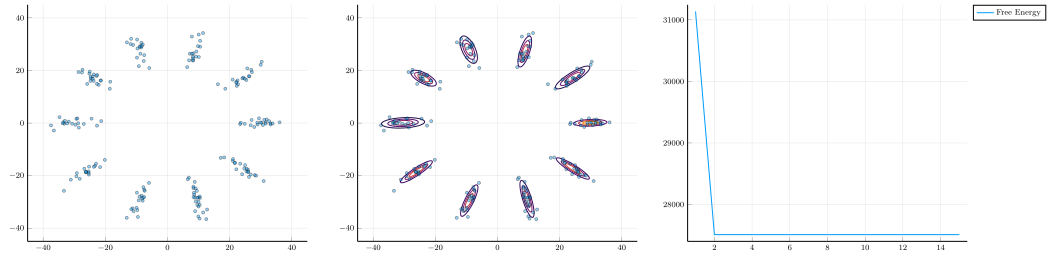

In [172]:
colors = palette(:tab20)

data_plot      = plot(y |> sdim(1), y |> sdim(2), xlim = (-1.5L, 1.5L), ylim = (-1.5L, 1.5L), ms = 2, alpha = 0.4, seriestype = :scatter, legend = false)
inference_plot = plot(y |> sdim(1), y |> sdim(2), xlim = (-1.5L, 1.5L), ylim = (-1.5L, 1.5L), ms = 2, alpha = 0.4, seriestype = :scatter, legend = false)

e_means = mean.(m[end])
e_precs = mean.(w[end])

for (e_m, e_w, c) in zip(e_means, e_precs, colors)
    gaussian = MvNormal(e_m, Matrix(Hermitian(inv(e_w))))
    inference_plot = contour!(inference_plot, range(-2L, 2L, step = 0.25), range(-2L, 2L, step = 0.25), (x, y) -> pdf(gaussian, [ x, y ]), levels = 3, colorbar = false)
end

pfe = plot(fe[1:end], label = "Free Energy")

plot(data_plot, inference_plot, pfe, size = (1400, 400), layout = @layout([ a b c ]))

In [173]:
savefig(data_plot, "./plots/gmm_data.tikz")
savefig(inference_plot, "./plots/gmm_inference.tikz")

In [169]:
import Pkg; Pkg.status(); versioninfo()

Status `~/Projects/LaTeX/RMP_Experiments/Project.toml`
  [6e4b80f9] BenchmarkTools v0.5.0
  [31c24e10] Distributions v0.24.12
  [b3f8163a] GraphPPL v0.1.0 `~/.julia/dev/GraphPPL.jl`
  [91a5bcdd] Plots v1.10.1
  [a194aa59] ReactiveMP v0.5.0 `~/.julia/dev/ReactiveMP`
  [df971d30] Rocket v1.3.3 `~/.julia/dev/Rocket`
Julia Version 1.5.3
Commit 788b2c77c1 (2020-11-09 13:37 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin18.7.0)
  CPU: Intel(R) Core(TM) i7-8850H CPU @ 2.60GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-9.0.1 (ORCJIT, skylake)
